In [3]:
import pandas as pd
from scipy.stats import randint


from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
df = pd.read_csv("fraud_reduced.csv", index_col=0)

X = df.drop("Class", axis=1)
y = df["Class"]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.33, stratify=y)

In [5]:
param_grid = {
    'n_estimators': randint(125, 150),  
    'max_depth': randint(5, 10),  
    'learning_rate': [0.01, 0.05, 0.1, 0.5],  
    'subsample': [0.7, 0.8, 0.9], 
    'scale_pos_weight': [1, 2, 3, 4],  
    'reg_alpha': [0.1, 0.5, 0.2],  
    'reg_lambda': [0.1, 0.5, 0.2]  
}


xgb_clf = XGBClassifier(n_jobs=-1)


param_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_grid,
    n_iter=15, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=None),  
    n_jobs=-1,  # Use all available CPU cores
    scoring=make_scorer(roc_auc_score, needs_threshold=True),
    verbose=2  
)


# Fit the RandomizedSearchCV to data
param_search.fit(X, y) 



Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           import...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E714917B80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E763926C80>,
                                        'reg_alpha': [0.1, 0.5, 0.2],
                                        'reg_lambda': [0.1, 0.5, 0.2],
                                        'scale_pos_weight': [1, 2, 3, 4],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring=make_scorer(roc_auc_score, needs_threshold=True),
                   verbose=2)

In [6]:
param_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 147,
 'reg_alpha': 0.2,
 'reg_lambda': 0.5,
 'scale_pos_weight': 4,
 'subsample': 0.8}

In [7]:
clf_rnd = param_search.best_estimator_

In [8]:
param_search.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 147,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.2,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': 4,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [9]:
cvres = param_search.cv_results_
results = [(mean_score, params) for mean_score, params in zip(cvres["mean_test_score"], cvres["params"])]
results.sort(reverse=True, key=lambda x: x[0])
for mean_score, params in results:
    print("ROC AUC", mean_score, "-", "Parameters:", params)

ROC AUC 0.9618403593721462 - Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 147, 'reg_alpha': 0.2, 'reg_lambda': 0.5, 'scale_pos_weight': 4, 'subsample': 0.8}
ROC AUC 0.9615502031226792 - Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 141, 'reg_alpha': 0.2, 'reg_lambda': 0.5, 'scale_pos_weight': 4, 'subsample': 0.7}
ROC AUC 0.9591063780681182 - Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 126, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'scale_pos_weight': 4, 'subsample': 0.7}
ROC AUC 0.9588801396542307 - Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 139, 'reg_alpha': 0.1, 'reg_lambda': 0.2, 'scale_pos_weight': 3, 'subsample': 0.9}
ROC AUC 0.9588433855166428 - Parameters: {'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 141, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'scale_pos_weight': 3, 'subsample': 0.8}
ROC AUC 0.9575178466119348 - Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 130,

In [10]:
clf_rnd = param_search.best_estimator_

In [11]:
y_pred = clf_rnd.predict(X_test)

[[93803    22]
 [   23   139]]


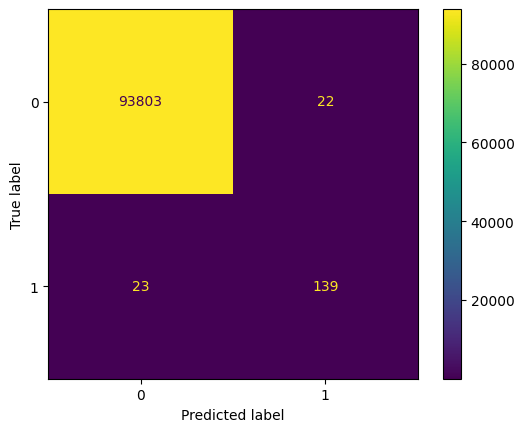

In [12]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rnd.classes_)
disp.plot()


- 93,809 instances were correctly classified as negative (True Negatives).
- 22 instances were incorrectly classified as positive when they were actually negative (False Positives).
- 23 instances were incorrectly classified as negative when they were actually positive (False Negatives).
- 139 instances were correctly classified as positive (True Positives).

In [13]:
# Calculate and display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.86      0.86      0.86       162

    accuracy                           1.00     93987
   macro avg       0.93      0.93      0.93     93987
weighted avg       1.00      1.00      1.00     93987



In [14]:
import joblib

joblib.dump(value= clf_rnd, filename='XGBModel.pkl')

['XGBModel.pkl']